In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import ali.methods
import ali.ui

In [2]:
# for id in os.listdir('output/my'):
#         if not "P" in id :continue
        
#         hr,step,rhr,info=ali.methods.load(id)
#         if info['covid_test_date']:
#             print(f'{id}')
# #             break
        
# #         alarms = pd.read_csv(f'output/my/{id}/alarm.csv',parse_dates=['datetime'],index_col='datetime').fillna(0)
# #         alarms['datetime'] = pd.to_datetime(alarms['datetime'])
# #         alarms = alarms.set_index('datetime')
# #         if not os.path.isfile(f'output/my/{id}/rhr.h5'):
# #             continue
        
# #         rhr = pd.read_hdf(f'output/my/{id}/rhr.h5', 'rhr',mode='r')
        
# #         display(rhr)



{'id': 'P476443', 'device': 'Fitbit', 'covid_test_date': Timestamp('2027-10-24 00:00:00'), 'symptom_date': Timestamp('2027-10-21 00:00:00')}


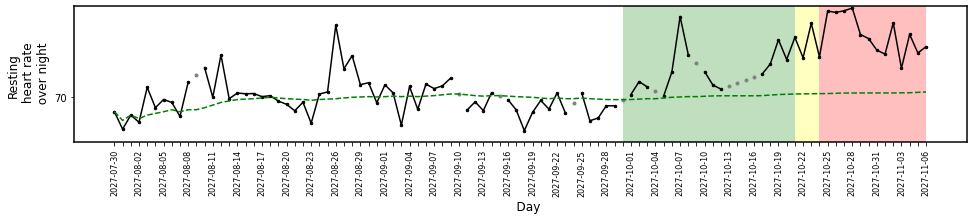

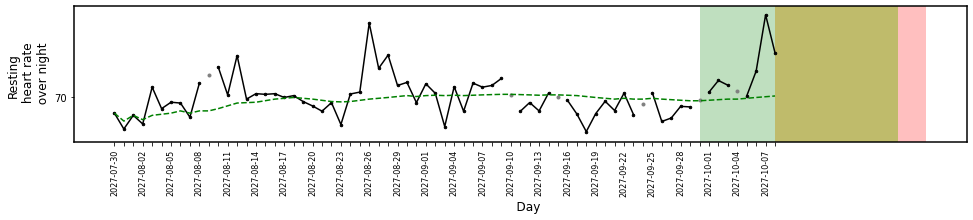

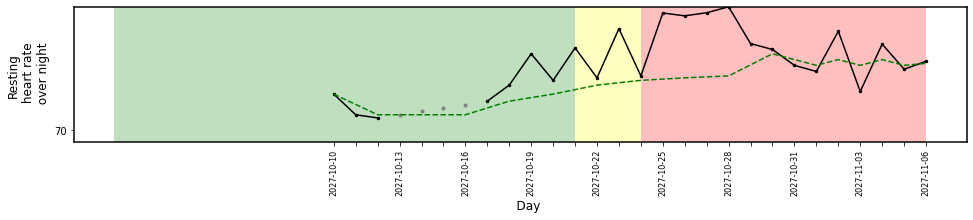

Training input shape:  (25432, 1260, 1)


In [3]:
id='P277912'
id='P476443'
seg='1T'
TIME_STEPS =int(pd.to_timedelta('7h')/pd.to_timedelta(seg)*3)

hr,step,rhr,info=ali.methods.load(id)
print(info)
ali.ui.plot(rhr,alerts=pd.DataFrame(),info=info,show=True)
rhr1=rhr.resample(seg).mean().dropna()
if info['covid_test_date']:
    if sum(rhr1.index<info['covid_test_date']-pd.to_timedelta('7d'))>TIME_STEPS*10:
        df_small_noise=rhr1.loc[rhr1.index<info['covid_test_date']-pd.to_timedelta('14d')]
        df_daily_jumpsup=rhr1.loc[rhr1.index>=info['covid_test_date']-pd.to_timedelta('14d')]
    else:
        df_small_noise = rhr1.loc[rhr1.index>info['covid_test_date']+pd.to_timedelta('14d')]
        df_daily_jumpsup = rhr1.loc[rhr1.index<=info['covid_test_date']+pd.to_timedelta('14d')]
    
else:
        df_small_noise=rhr1.loc[rhr1.index<rhr1.index[0]+pd.to_timedelta('28d')]
        df_daily_jumpsup=rhr1.loc[rhr1.index>=rhr1.index[0]+pd.to_timedelta('28d')]

ali.ui.plot(df_small_noise,alerts=pd.DataFrame(),info=info,show=True)
ali.ui.plot(df_daily_jumpsup,alerts=pd.DataFrame(),info=info,show=True)

# display(rhr)
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std



# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)


In [4]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 630, 32)           256       
                                                                 
 dropout (Dropout)           (None, 630, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 315, 16)           3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 630, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 630, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 1260, 32)         3616      
 ranspose)                                              

In [5]:

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Epoch 1/50
 47/179 [======>.......................] - ETA: 10s - loss: 0.4731

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-483fab982793>", line 1, in <module>
    history = model.fit(
  File "/opt/conda/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  File "/opt/conda/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
    result = self._call(*args, **kwds)
  File "/opt/conda/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 942, in _call
    return self._stateless_fn(*args, **

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


In [ ]:

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if (sum(anomalies[data_idx - TIME_STEPS + 1 : data_idx]))>TIME_STEPS/6:
#     if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print(f'size={len(anomalous_data_indices)}')

In [ ]:
anomalous_data_indices=np.where(anomalies)
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
fig.set_figwidth(15)

df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")

if(info['covid_test_date']!=None):
        plt.axvspan(info['covid_test_date'], min(df_daily_jumpsup.index[-1], info['covid_test_date']+pd.to_timedelta('7d')), facecolor='red', alpha=0.25, label='Covid')
        plt.axvspan(info['covid_test_date'], max(df_daily_jumpsup.index[1], info['covid_test_date']-pd.to_timedelta('7d')), facecolor='yellow', alpha=0.25, label='Covid')
plt.show()

In [ ]:
dates=df_daily_jumpsup.iloc[anomalous_data_indices].resample('1D').count().fillna(0).rename(columns={'heartrate':'count'})


dates['alarm']=(dates['count']>0)*2
ali.ui.plot(rhr,alerts=dates,info=info,show=True)

In [ ]:
import compress_pickle
compress_pickle.dump([x_train,x_test],'tmp.pkl')
compress_pickle.dump([df_small_noise,df_daily_jumpsup],'tmp2.pkl')

